In [1]:
###############
### IMPORTS ###
###############

from scipy.io import readsav
import numpy as np
from aiapy.calibrate import degradation, register, update_pointing
from astropy.io import fits
from sunpy.net import Fido, attrs
import sunpy.map
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# Set the date of your dataset:
date='20140313'

In [3]:
datadir='./data/'

In [4]:
# Read-in AIA fits files. These are level 1.5 files (full Sun), 
# rebinned to 1024x1024 and normalised by exposure time (unit: [DN/s])
fcube304 = fits.open(datadir+'AIA20140313_0304_rbn.fits',mode='readonly')
fcube335 = fits.open(datadir+'AIA20140313_0335_rbn.fits',mode='readonly')
fcube131 = fits.open(datadir+'AIA20140313_0131_rbn.fits',mode='readonly')
fcube171 = fits.open(datadir+'AIA20140313_0171_rbn.fits',mode='readonly')
fcube193 = fits.open(datadir+'AIA20140313_0193_rbn.fits',mode='readonly')
fcube211 = fits.open(datadir+'AIA20140313_0211_rbn.fits',mode='readonly')
fcube094 = fits.open(datadir+'AIA20140313_0094_rbn.fits',mode='readonly')

In [5]:
data304 = fcube304[0].data
data304 = data304.astype(float, copy=False)
hdr304 = fcube304[0].header
data335 = fcube335[0].data
data335 = data335.astype(float, copy=False)
hdr335 = fcube335[0].header
data131 = fcube131[0].data
data131 = data131.astype(float, copy=False)
hdr131 = fcube131[0].header
data171 = fcube171[0].data
data171 = data171.astype(float, copy=False)
hdr171 = fcube171[0].header
data193 = fcube193[0].data
data193 = data193.astype(float, copy=False)
hdr193 = fcube193[0].header
data211 = fcube211[0].data
data211 = data211.astype(float, copy=False)
hdr211 = fcube211[0].header
data094 = fcube094[0].data
data094 = data094.astype(float, copy=False)
hdr094 = fcube094[0].header

In IDL:
Produce the AIA temperature response function with SSWIDL with the following keywords:

    aia_resp = aia_get_response(/dn,/temp,/chiantifix,/eve,timedepend_date=date)

Save the structure into an IDL save file:

    ex = 'save,aia_resp,filename='+'"'datadir+'aia_resp_'+date+'.sav'+'"'
    void = execute(ex)

In [6]:
# Reads response function:
def get_response(date):
    # FAUCHERE FUNCTION

    sav_of_date=datadir+'aia_resp_'+date+'.sav'
    
    r=readsav(sav_of_date)
    
    r94=r['aia_resp']['a94']
    out_94 = (r94[0]['logte'][0],r94[0]['tresp'][0])

    r131=r['aia_resp']['a131']
    out_131 = (r131[0]['logte'][0],r131[0]['tresp'][0])

    r171=r['aia_resp']['a171']
    out_171 = (r171[0]['logte'][0],r171[0]['tresp'][0])

    r193=r['aia_resp']['a193']
    out_193 = (r193[0]['logte'][0],r193[0]['tresp'][0])

    r211=r['aia_resp']['a211']
    out_211 = (r211[0]['logte'][0],r211[0]['tresp'][0])

    r304=r['aia_resp']['a304']
    out_304 = (r304[0]['logte'][0],r304[0]['tresp'][0])

    r335=r['aia_resp']['a335']
    out_335 = (r335[0]['logte'][0],r335[0]['tresp'][0])

    return out_94,out_131,out_171,out_193,out_211,out_335,out_304

In this example, the DEM is calculated with the Simple Regularisation method 2020, ApJ 905, 17). This is performed in IDL, with the simple_reg_dem.pro routine on solarsoft. The data used for the DEM is rebinned to 1024x1024 to avoid overly large files. For this we define 17 temperature bins from log T = 5.5 to 7.1, with a 0.1 temperature step in log space. 

In [9]:
#DEM method
# read-in DEM file containing 
files = sorted(glob.glob(datadir+"*_smreg_*0.1_rbn.sav"))
params = readsav(files[0])
y = params.demcube
lgtaxis = params.lgtaxis

Text(0.5, 1.0, '  Log EM \n[cm$^{-5}$]')

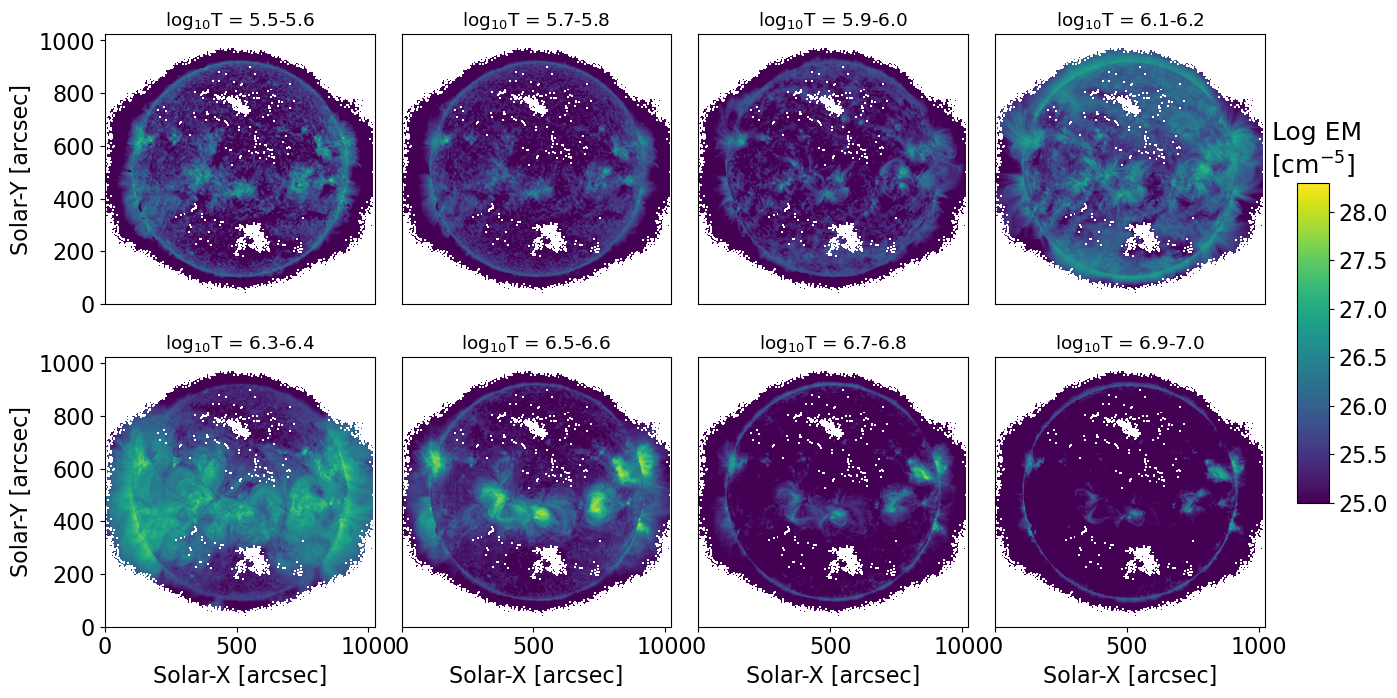

In [11]:
# plot a few of the temperature maps of the DEM: 
# Note that to pass from DEM to EM we need to multiply by the temperature bin width (dlgt)
plt.rcParams.update({'font.size': 16})
fig,ax=plt.subplots(2,4,figsize=(8*2,8))
fig.subplots_adjust(wspace=0.1,hspace=0.1)
dlgt = 0.1

for i in range(0,2):
    jj = 0
    for j in range(0,8,2):
        vmin = 1.0e25
        vmax = 2.0e28
        im = ax[i,jj].imshow(np.log10(y[i*8+j,:,:]*dlgt),vmin=np.log10(vmin),vmax=np.log10(vmax),cmap='viridis',origin='lower')
        if (j==2 and i==0):
            ax[i,jj].set_title('log$_{10}$T = '+str(lgtaxis[i*8+j])+'-'+str(lgtaxis[i*8+j+1]),size='small')
        else:
            ax[i,jj].set_title('log$_{10}$T = '+str(lgtaxis[i*8+j])+'-'+str(lgtaxis[i*8+j+1]),size='small')
        if (jj != 0): 
            ax[i,jj].get_yaxis().set_visible(False)
        else:
            ax[i,jj].set_ylabel('Solar-Y [arcsec]')
        if (i == 0): 
            ax[i,jj].get_xaxis().set_visible(False)
        else:
            ax[i,jj].set_xlabel('Solar-X [arcsec]')
        jj = jj+1

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.28, 0.02, 0.4])
cb = fig.colorbar(im,cax=cbar_ax)
cb.ax.set_title('  Log EM \n[cm$^{-5}$]',fontsize=18)

In [12]:
# We now need to convolve the DEM results with the hot part of the 304 response function. We first read it in:
r0= get_response(date)
r304_0= r0[6]
r304_0 = np.array(r304_0)
logT = r304_0[0]
logT=np.array(logT)

(-1.5, 6.0)

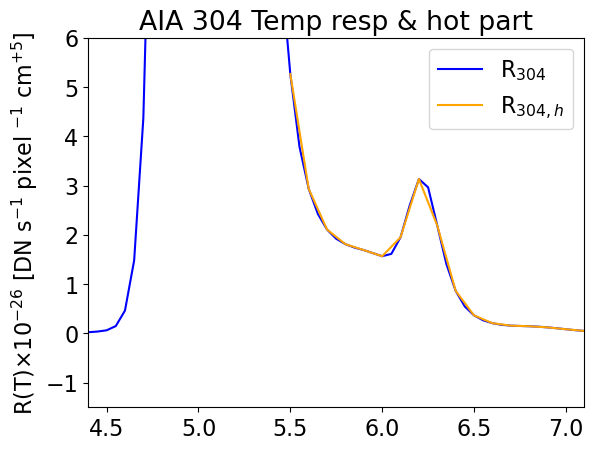

In [27]:
# We define the hot part as the temperature range above log T  = 5.5
from scipy import interpolate

ny,nx = data304.shape
r304_to_decompose = r304_0[1].copy()
t_thres = 5.5
r304_to_decompose[ logT<t_thres ] = 0
tresp = r304_to_decompose
f = interpolate.interp1d(logT, tresp)
t304resp = f(lgtaxis)
plt.plot(logT,r304_0[1]/1e-27,color='blue')
#plt.plot(logT,tresp,color='blue')
plt.plot(lgtaxis,t304resp/1e-27,color='orange')
plt.ylabel('R(T)'+r'$\times10^{-26}}$ [DN s$^{-1}$ pixel $^{-1}$ cm$^{+5}$]')
plt.title('AIA 304 Temp resp & hot part')
plt.legend(['R$_{304}$','R$_{304,h}$'])
plt.xlim(4.4,7.1)
plt.ylim(-1.5,6)

In [28]:
AIA304hot_dem = np.zeros((ny,nx))

for i in range(0,ny):
    for j in range(0,nx):
        AIA304hot_dem[i,j] = np.dot(t304resp.T,y[:,i,j].flatten().T).T#*1e26

In [29]:
AIA304hot_dem = AIA304hot_dem*dlgt

In [31]:
AIA304cool_dem = np.zeros((ny,nx))
AIA304cool_dem = data304-AIA304hot_dem

Text(0.5, 1.0, 'DN/s')

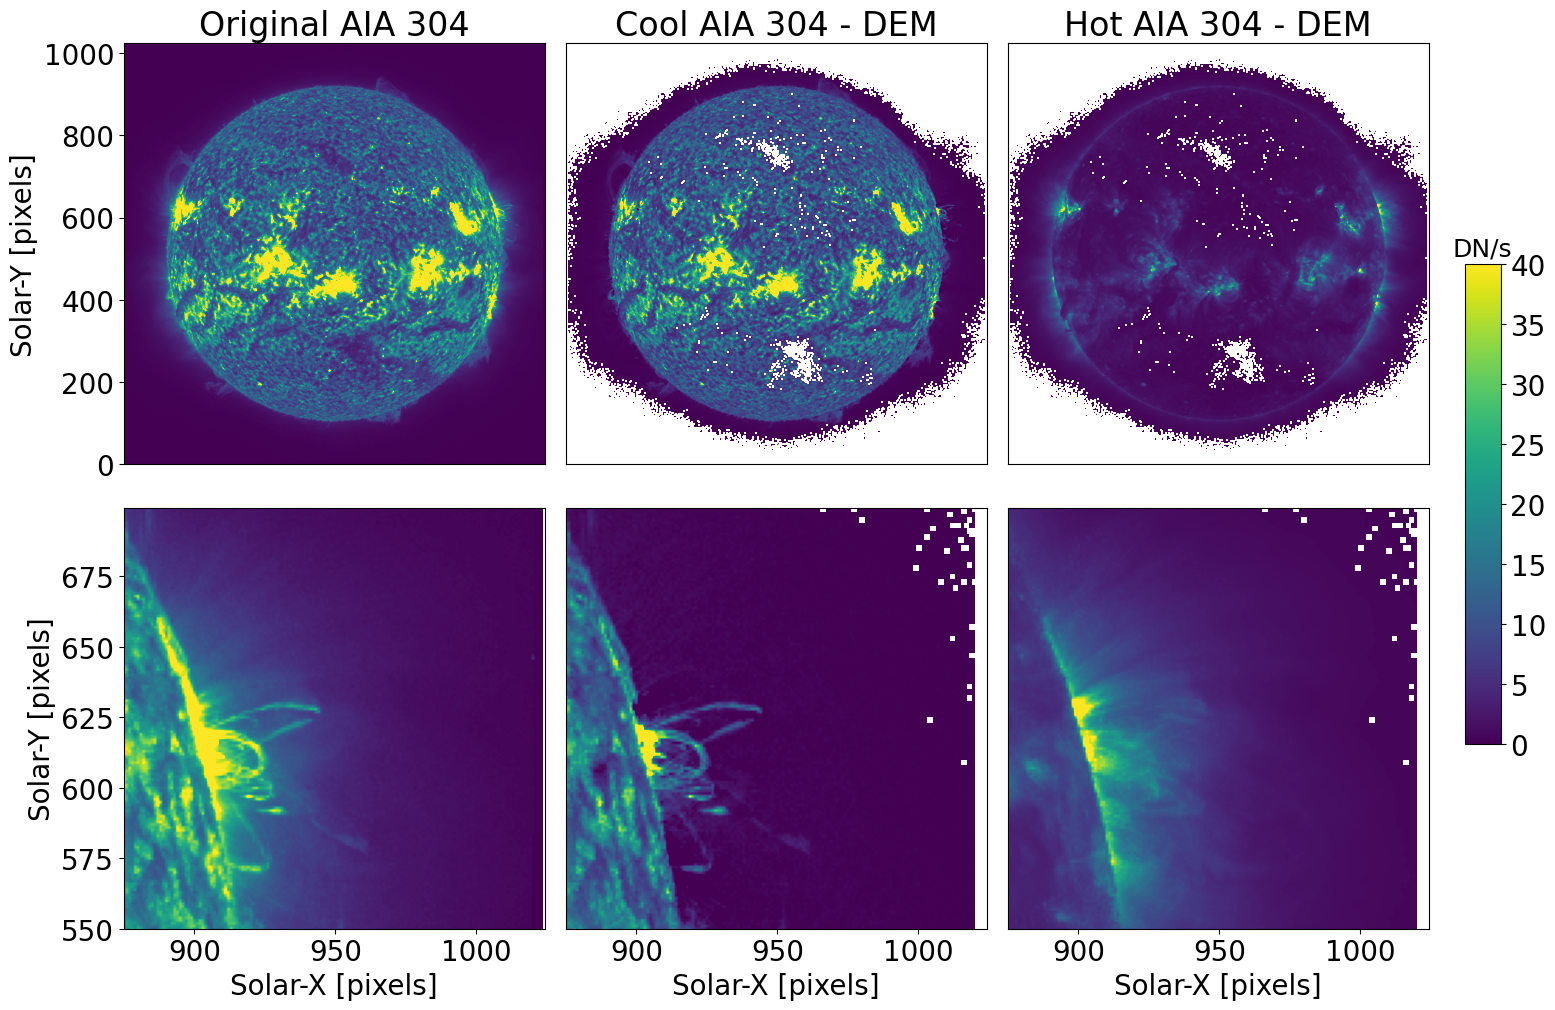

In [32]:
# Plot result
i = 0
vmax = 40
x0 = 3500/4
x1 = 4097/4
y0 = 2200/4
y1 = y0+(x1-x0)
plt.rcParams.update({'font.size': 20})
fig,ax=plt.subplots(nrows=2,ncols=3,figsize=(18,12))
fig.subplots_adjust(wspace=0.05,hspace=0.01)
im1 = ax[0,0].imshow(data304,vmin=0,vmax=vmax,origin='lower')
ax[0,0].set_title('Original AIA 304')
ax[0,0].get_xaxis().set_visible(False)
ax[0,0].set_ylabel('Solar-Y [pixels]')
im2 = ax[0,1].imshow(AIA304cool_dem,vmin=0,vmax=vmax,origin='lower')
ax[0,1].set_title('Cool AIA 304 - DEM')
ax[0,1].get_xaxis().set_visible(False)
ax[0,1].get_yaxis().set_visible(False)
im3 = ax[0,2].imshow(AIA304hot_dem,vmin=0,vmax=vmax,origin='lower')
ax[0,2].set_title('Hot AIA 304 - DEM')
ax[0,2].get_xaxis().set_visible(False)
ax[0,2].get_yaxis().set_visible(False)
im4 = ax[1,0].imshow(data304,vmin=0,vmax=vmax,origin='lower')
ax[1,0].set_xlabel('Solar-X [pixels]')
ax[1,0].set_ylabel('Solar-Y [pixels]')
ax[1,0].set_xlim(x0,x1)
ax[1,0].set_ylim(y0,y1)
im5 = ax[1,1].imshow(AIA304cool_dem,vmin=0,vmax=vmax,origin='lower')
ax[1,1].set_xlabel('Solar-X [pixels]')
ax[1,1].get_yaxis().set_visible(False)
ax[1,1].set_xlim(x0,x1)
ax[1,1].set_ylim(y0,y1)
im6 = ax[1,2].imshow(AIA304hot_dem,vmin=0,vmax=vmax,origin='lower')
ax[1,2].set_xlabel('Solar-X [pixels]')
ax[1,2].get_yaxis().set_visible(False)
ax[1,2].set_xlim(x0,x1)
ax[1,2].set_ylim(y0,y1)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.28, 0.02, 0.4])
cb = fig.colorbar(im3,cax=cbar_ax)
cb.ax.set_title('DN/s',fontsize=18)